In [8]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Original network")
RESULTS_DIR = os.path.join(SCENARIO_DIR, "results")

# Create results folder if it doesn't exist
if not os.path.exists(RESULTS_DIR):
    print(f"Creating results folder: {RESULTS_DIR}")
    os.makedirs(RESULTS_DIR, exist_ok=True)

# Definition of the two directions
DIR_A_EDGES = ["E0E1", "E1E2", "E2E3", "E3E4", "E4E5"]  # Forward (E0 -> E5)
DIR_B_EDGES = ["E5E4", "E4E3", "E3E2", "E2E1", "E1E0"]  # Backward (E5 -> E0)


## 2. Network & Traffic Light Analysis
✅ Network Summary:
   - Edges: 400
   - Nodes: 112 (Traffic Lights: 16)

## 3. Demand Profiles & Multimodal Flow
📊 DEBUG: Found 80648 total elements.
   Breakdown: {'flow': 80648}

- **Fleet Analysis:**
   - **DEFAULT_BIKETYPE**: 4 units (Primary Destination: D1D0)
   - **t_0**: 4 units (Primary Destination: C1C0)
   - **car**: 80640 units (Primary Destination: D1D0)


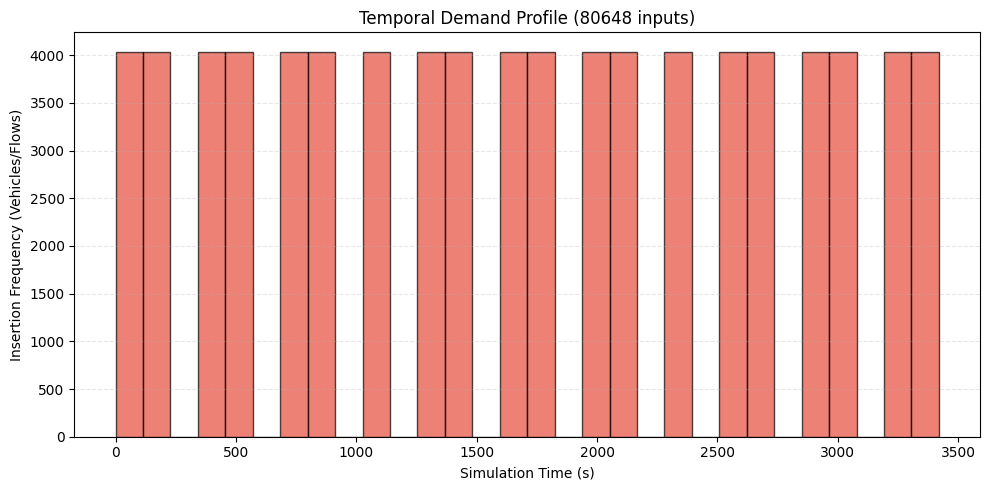

In [37]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

# --- MAPPING & ANALYSIS FUNCTIONS ---

def analyze_network_and_tls(path):
    """
    Analyzes basic network properties and Traffic Light Systems (TLS).
    Added to ensure the script is complete.
    """
    print(f"\n## 2. Network & Traffic Light Analysis")
    if not os.path.exists(path):
        print(f"❌ ERROR: Network file not found: {path}")
        return

    tree = ET.parse(path)
    root = tree.getroot()
    
    edges = root.findall('edge')
    nodes = root.findall('junction')
    tls = [n for n in nodes if n.get('type') == 'traffic_light']
    
    print(f"✅ Network Summary:")
    print(f"   - Edges: {len(edges)}")
    print(f"   - Nodes: {len(nodes)} (Traffic Lights: {len(tls)})")

def analyze_demand_details(path):
    print(f"\n## 3. Demand Profiles & Multimodal Flow")
    
    # Preliminary Check
    if not os.path.exists(path):
        print(f"❌ ERROR: File not found: {path}")
        return

    tree = ET.parse(path)
    root = tree.getroot()
    
    depart_times = []
    vehicle_data = []
    
    # Debug counters
    stats_tags = Counter()

    # Helper function to extract data from any tag (vehicle/trip/flow)
    def extract_data(elem, tag_type):
        stats_tags[tag_type] += 1
        
        # 1. Vehicle Type
        v_type = elem.get('type', 'default')
        
        # 2. Departure Time
        # vehicles/trips use 'depart', flows use 'begin'
        t_val = elem.get('depart')
        if t_val is None:
            t_val = elem.get('begin')
        
        if t_val:
            try:
                depart_times.append(float(t_val))
            except ValueError:
                pass # Ignore values like 'triggered'

        # 3. Destination
        dest = "N/A"
        # Case A: Route defined inside the element
        route = elem.find('route')
        if route is not None and route.get('edges'):
            dest = route.get('edges').split()[-1]
        # Case B: Direct 'edges' attribute (e.g., in flows)
        elif elem.get('edges'):
            dest = elem.get('edges').split()[-1]
        # Case C: 'to' attribute (used in trips)
        elif elem.get('to'):
            dest = elem.get('to')
            
        vehicle_data.append({'type': v_type, 'dest': dest})

    # Search for ALL traffic definition types
    for tag in ['vehicle', 'trip', 'flow']:
        for item in root.findall(tag):
            extract_data(item, tag)

    # --- DEBUG OUTPUT ---
    print(f"📊 DEBUG: Found {sum(stats_tags.values())} total elements.")
    print(f"   Breakdown: {dict(stats_tags)}")
    
    if not depart_times:
        print("⚠️ WARNING: No temporal data found. The plot will be empty.")
        print("   Check the .rou.xml file: does it use complex namespaces or nested definitions?")
        return

    # Fleet and direction statistics
    print(f"\n- **Fleet Analysis:**")
    counts = Counter([v['type'] for v in vehicle_data])
    for v_type, num in counts.items():
        # Filter destinations for this specific type
        dests = [v['dest'] for v in vehicle_data if v['type'] == v_type and v['dest'] != "N/A"]
        if dests:
            main_dest = Counter(dests).most_common(1)[0][0]
            print(f"   - **{v_type}**: {num} units (Primary Destination: {main_dest})")
        else:
            print(f"   - **{v_type}**: {num} units (Destinations not deducible)")

    # Plotting
    plt.figure(figsize=(10, 5))
    # Using a professional red-orange color
    plt.hist(depart_times, bins=30, color='#e74c3c', edgecolor='black', alpha=0.7)
    plt.title(f"Temporal Demand Profile ({sum(stats_tags.values())} inputs)")
    plt.xlabel("Simulation Time (s)")
    plt.ylabel("Insertion Frequency (Vehicles/Flows)")
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
if __name__ == "__main__":
    # Ensure SCENARIO_DIR is defined, otherwise use current directory
    if 'SCENARIO_DIR' not in globals():
        SCENARIO_DIR = os.getcwd() 
        
    net_path = str(Path(os.path.join(SCENARIO_DIR, "ff.net.xml")).resolve())
    route_path = str(Path(os.path.join(SCENARIO_DIR, "ff_heterogeneous.rou.xml")).resolve())

    # Run Analysis
    analyze_network_and_tls(net_path)
    analyze_demand_details(route_path)

⏳ Loading route data and counting edge demand...
✅ Data extracted: 80 active edges processed.
🗺️ Rendering network map with lane division...


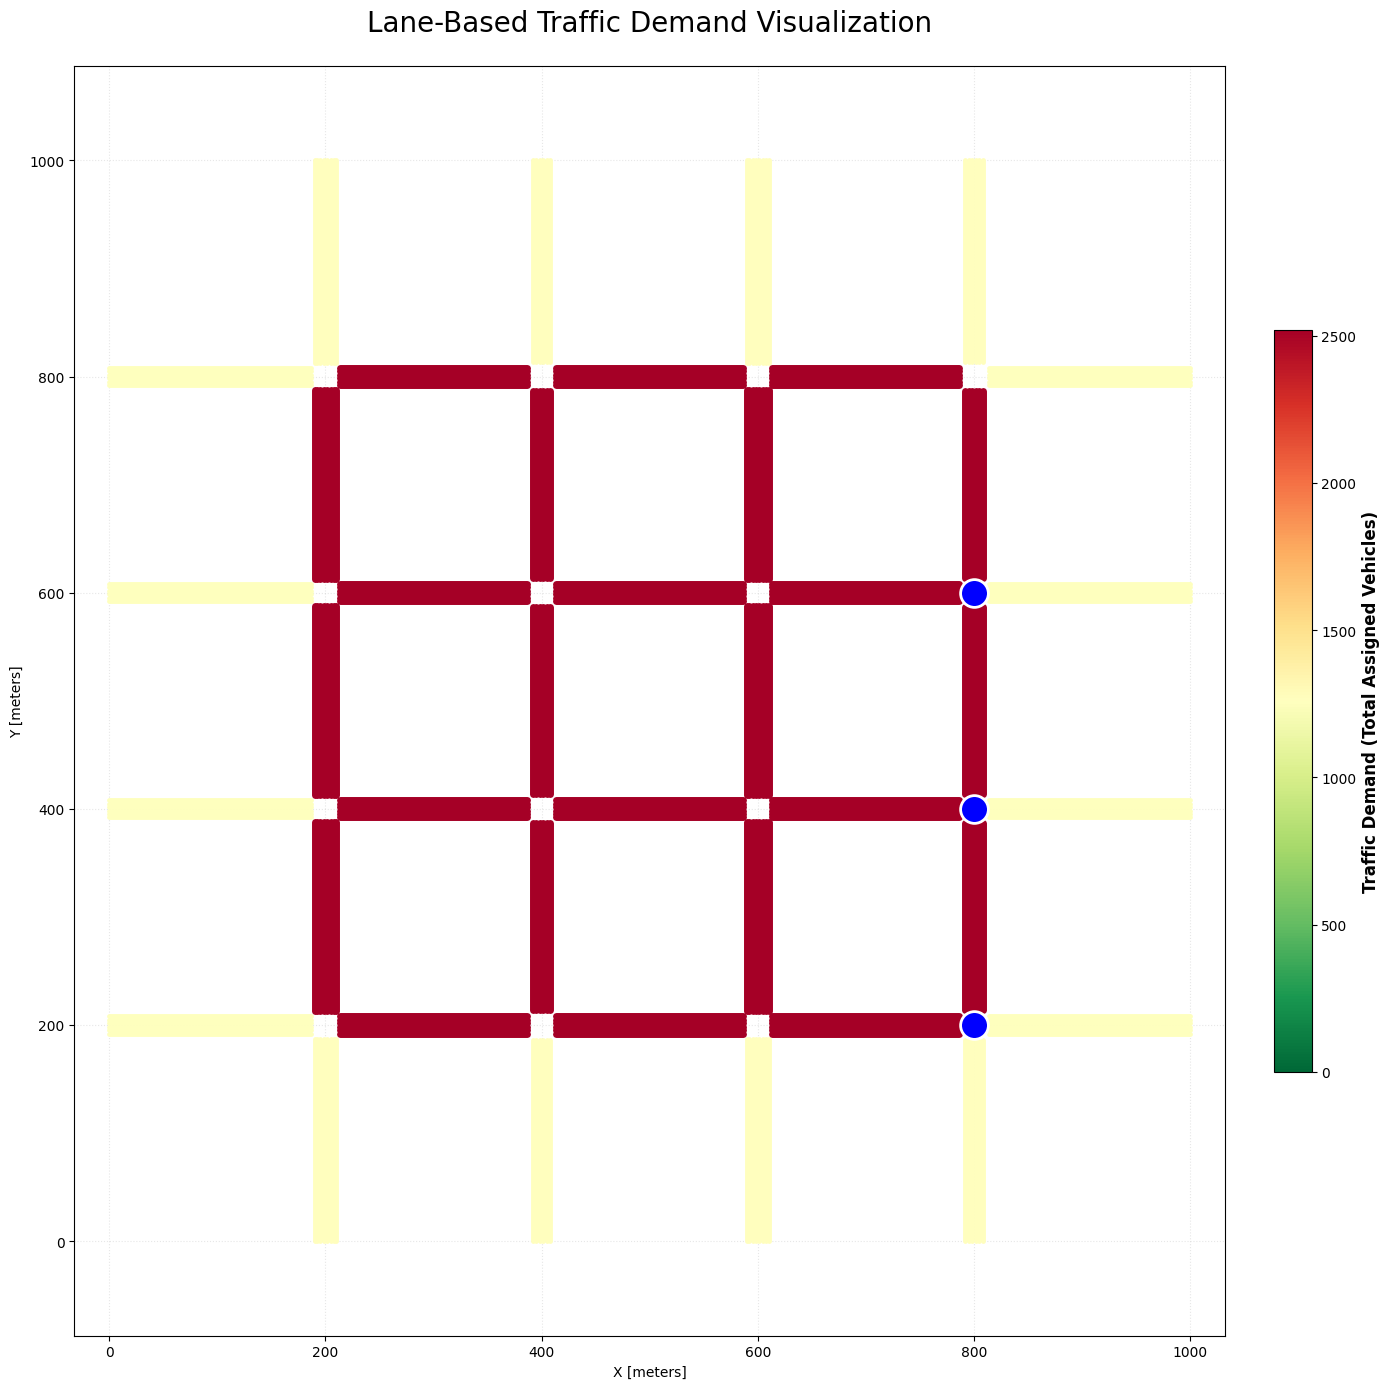

In [35]:
import os
import sumolib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xml.etree.ElementTree as ET
from pathlib import Path

# --- CONFIGURATION ---
net_path = Path(SCENARIO_DIR) / "ff.net.xml"
route_path = Path(SCENARIO_DIR) / "ff_heterogeneous.rou.xml"

def plot_lane_network_load_map(net_file, route_file):
    print("⏳ Loading route data and counting edge demand...")
    
    if not route_file.exists():
        print(f"❌ ERROR: Route file {route_file} not found.")
        return

    # 1. ROUTE PARSING
    tree = ET.parse(route_file)
    root = tree.getroot()
    edge_counts = {}

    def process_edges(edge_string):
        if not edge_string: return
        edges = edge_string.split()
        for e in edges:
            edge_counts[e] = edge_counts.get(e, 0) + 1

    for tag in ['vehicle', 'flow', 'trip']:
        for item in root.findall(tag):
            route_tag = item.find('route')
            if route_tag is not None and route_tag.get('edges'):
                process_edges(route_tag.get('edges'))
            elif item.get('edges'):
                process_edges(item.get('edges'))
            elif item.get('from') and item.get('to'):
                edge_counts[item.get('from')] = edge_counts.get(item.get('from'), 0) + 1
                edge_counts[item.get('to')] = edge_counts.get(item.get('to'), 0) + 1

    print(f"✅ Data extracted: {len(edge_counts)} active edges processed.")

    # 2. SPATIAL MAP GENERATION
    print("🗺️ Rendering network map with lane division...")
    
    # Load Network with URI fix for Windows compatibility
    net = sumolib.net.readNet(net_file.resolve().as_uri())
    
    fig, ax = plt.subplots(figsize=(14, 14))
    ax.set_facecolor('white')
    
    if edge_counts:
        max_load = max(edge_counts.values())
        norm = mcolors.Normalize(vmin=0, vmax=max_load)
        # Using Red-Yellow-Green (reversed) so Red = High Demand
        cmap = plt.get_cmap('RdYlGn_r') 
    else:
        print("⚠️ No demand data found to color the map.")
        return

    # 3. LANE-BY-LANE RENDERING
    for edge in net.getEdges():
        eid = edge.getID()
        # Skip internal SUMO lanes (junction rungs) for a cleaner look
        if eid.startswith(':'): continue 
            
        count = edge_counts.get(eid, 0)
        
        # Color and width logic
        if count > 0:
            color = cmap(norm(count))
            # Base width + proportional demand width
            lw = 2.0 + (count / max_load) * 3 
            z = 10
        else:
            color = '#f0f0f0' # Very light gray for empty roads
            lw = 1.0
            z = 1
            
        # Draw each lane individually
        for lane in edge.getLanes():
            shape = lane.getShape()
            xs, ys = zip(*shape)
            ax.plot(xs, ys, color=color, linewidth=lw, zorder=z, solid_capstyle='round')

    # 4. COLORBAR
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Traffic Demand (Total Assigned Vehicles)', fontsize=12, fontweight='bold')

    # 5. HIGHLIGHT NODES E1, E2, E3
    for node_id in ['E1', 'E2', 'E3']:
        node = net.getNode(node_id)
        if node:
            x, y = node.getCoord()
            ax.scatter(x, y, s=400, c='blue', marker='o', zorder=50, edgecolors='white', linewidth=2)
            # Label with a slight vertical offset
            ax.text(x, y+25, node_id, color='blue', fontsize=14, fontweight='black', 
                    ha='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.title("Lane-Based Traffic Demand Visualization", fontsize=20, pad=25)
    plt.xlabel("X [meters]", fontsize=10)
    plt.ylabel("Y [meters]", fontsize=10)
    plt.axis('equal')
    plt.grid(True, linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if net_path.exists() and route_path.exists():
        plot_lane_network_load_map(net_path, route_path)
    else:
        print("❌ Error: One or more files are missing. Check your paths.")

⏳ Generating Green-Red map with large labels...
🗺️ Rendering links and speeds...


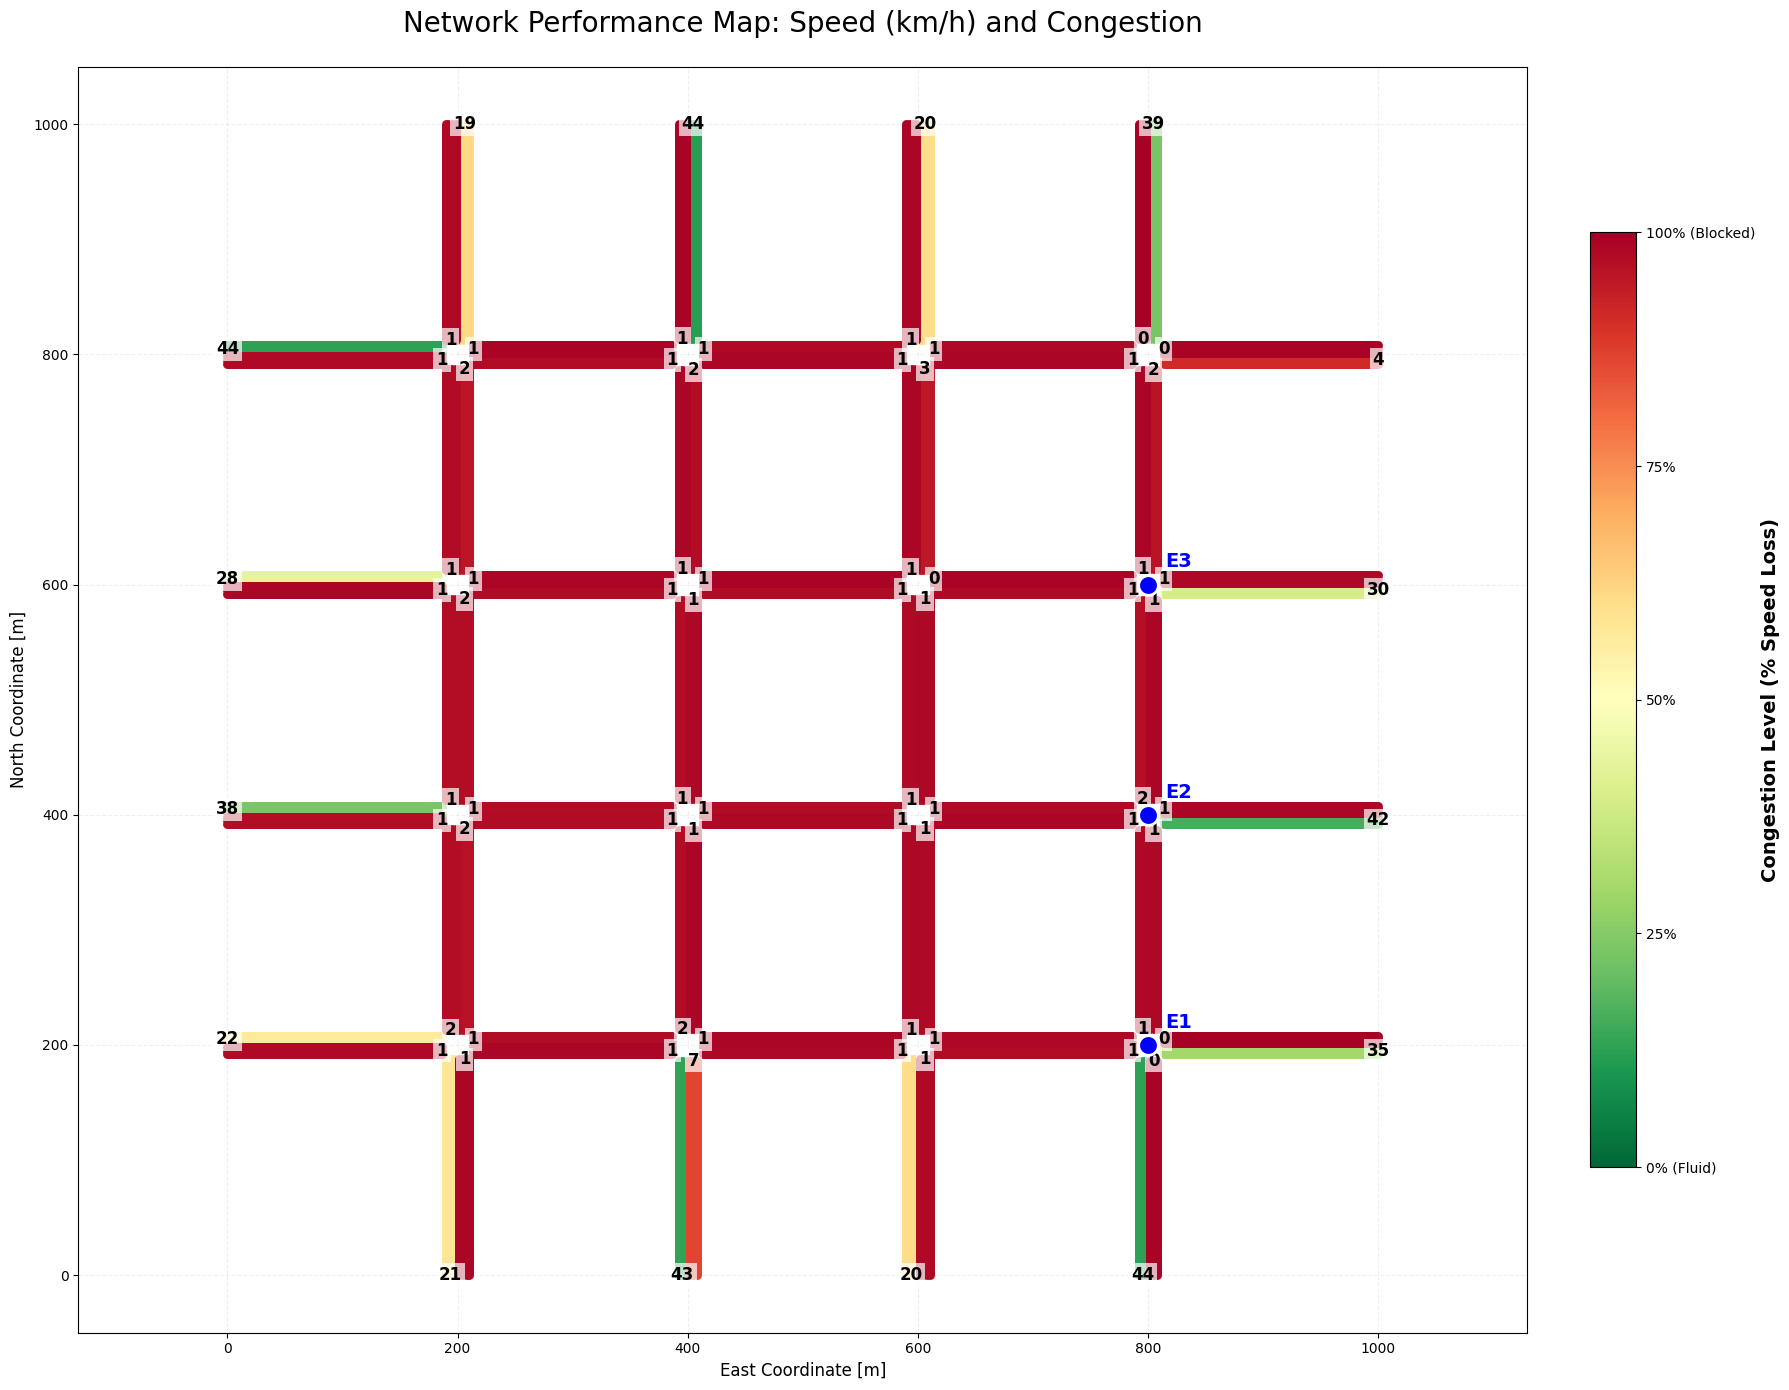

In [31]:
import os
import sumolib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xml.etree.ElementTree as ET
from pathlib import Path

def plot_congestion_heatmap(net_file, data_file):
    print("⏳ Generating Green-Red map with large labels...")
    
    if not data_file.exists():
        print(f"❌ ERROR: File {data_file} does not exist.")
        return

    # 1. Network Loading (Windows URI Fix)
    net = sumolib.net.readNet(net_file.resolve().as_uri())
    
    # 2. Result Parsing
    edge_speeds = {}
    tree = ET.parse(data_file)
    root = tree.getroot()
    
    for interval in root.findall('interval'):
        for edge in interval.findall('edge'):
            eid = edge.get('id')
            try:
                speed = float(edge.get('speed'))
                if eid not in edge_speeds:
                    edge_speeds[eid] = []
                edge_speeds[eid].append(speed)
            except (ValueError, TypeError):
                pass

    # 3. Plot Preparation
    fig, ax = plt.subplots(figsize=(18, 14))
    ax.set_facecolor('white')
    
    # Colormap: Green (0) -> Yellow -> Red (1)
    # We use 'RdYlGn_r' because we want Red for high values (congestion)
    cmap = plt.get_cmap('RdYlGn_r')
    
    print("🗺️ Rendering links and speeds...")
    for edge in net.getEdges():
        eid = edge.getID()
        avg_speed_ms = sum(edge_speeds[eid]) / len(edge_speeds[eid]) if eid in edge_speeds else None
        speed_limit = edge.getSpeed()
        
        # Congestion Calculation (0.0 = Fluid/Green, 1.0 = Blocked/Red)
        congestion = 0.0
        if avg_speed_ms is not None and speed_limit > 0.1:
            congestion = max(0.0, min(1.0, 1.0 - (avg_speed_ms / speed_limit)))

        # 4. Drawing Lanes
        for lane in edge.getLanes():
            shape = lane.getShape()
            xs, ys = zip(*shape)
            
            if avg_speed_ms is not None:
                color = cmap(congestion)
                lw = 3.0 + (speed_limit / 4.0) # Thicker lines
                z = 10 + (congestion * 50)
            else:
                color = '#f0f0f0' # Almost invisible gray if no traffic
                lw = 1.0
                z = 1
            
            ax.plot(xs, ys, color=color, linewidth=lw, zorder=z, solid_capstyle='round')

        # 5. Large Speed Labels at the center of the Link
        if avg_speed_ms is not None:
            avg_speed_kmh = avg_speed_ms * 3.6
            shape = edge.getShape()
            
            # Geometric midpoint calculation for the road
            mid_idx = len(shape) // 2
            mid_x, mid_y = shape[mid_idx]
            
            # Larger, more readable text with semi-transparent background
            ax.text(mid_x, mid_y, f"{avg_speed_kmh:.0f}", 
                    color='black', fontsize=12, fontweight='bold',
                    ha='center', va='center', zorder=150,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))

    # 6. Graduated Scale (Colorbar)
    norm = mcolors.Normalize(vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Congestion Level (% Speed Loss)', fontsize=14, fontweight='bold')
    
    # Ticks fix
    tick_locs = [0, 25, 50, 75, 100]
    cbar.set_ticks(tick_locs)
    cbar.ax.set_yticklabels(['0% (Fluid)', '25%', '50%', '75%', '100% (Blocked)'])

    # 7. Finalization
    plt.title("Network Performance Map: Speed (km/h) and Congestion", fontsize=20, pad=25)
    plt.xlabel("East Coordinate [m]", fontsize=12)
    plt.ylabel("North Coordinate [m]", fontsize=12)
    
    # Highlight Target nodes
    for node_id in ['E1', 'E2', 'E3']:
        node = net.getNode(node_id)
        if node:
            x, y = node.getCoord()
            ax.scatter(x, y, s=200, c='blue', marker='o', zorder=200, edgecolors='white', linewidth=2)
            ax.text(x+15, y+15, node_id, color='blue', fontsize=14, fontweight='bold', zorder=201)

    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_congestion_heatmap(net_path, output_data_path)

NameError: name 'net' is not defined